# Wasserstein GAN

## Your task
1.   Learn and summarize WGAN with respect to: Architecture, Cost Funstion, Latent Space, Training Tricks, etc..
2.   Try to change the dataset to CelebA Face dataset


## 1. Research Paper

* [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)

## 2. Background

Brief definition of some concepts, such as Wasserstein distance.

### Wasserstein distance

The Wasserstein distance is the cost of the cheapest transport plan or the minimum cost of transporting mass in converting the data distribution $q$ to the data distribution $p$. 

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

Wasserstein GAN (WGAN) proposes a new cost function using Wasserstein distance that has a smoother gradient everywhere. This model is proposed to measure the difference between the data distributions of real and generated images.

This network is very similar to the discriminator **$D$**, just without the sigmoid function and outputs a scalar score rather than a probability.

The discriminator **$D$** is rename to **Critic** to reflect its new role. 


### Cost Funcion

| Model | Discriminator/Critic | Generator             |
|:-----:|:--------------------:|:---------------------:|
| **GAN**   |  $$ \nabla_{\theta_{d}}\frac{1}{m}\sum_{i=1}^{m} [log(D(x^{(i)})) + log(1-D(G(z^{(i)})))]$$ | $$ \nabla_{\theta_{g}}\frac{1}{m}\sum_{i=1}^{m} -log(D(G(z^{(i)})))$$|
| **WGAN**  |$$ \nabla_{w}\frac{1}{m}\sum_{i=1}^{m} [f(x^{(i)}) - f(G(z^{(i)}))]$$ | $$ \nabla_{\theta_{g}}\frac{1}{m}\sum_{i=1}^{m} -f(G(z^{(i)}))$$|

* **Wasserstein objective:**

```
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)
```    
* **Critic training:**

1. Maximize $\frac{1}{m}\sum_{i=1}^{m} f(x^{(i)})$
* Minimize $\frac{1}{m}\sum_{i=1}^{m} f(G(z^{(i)}))$
* Weight clipping:

```
for l in critic.layers:
    weights = l.get_weights()
    weights = [np.clip(w, -clip_value, clip_value) for w in weights]
    l.set_weights(weights)
```

* **Generator training:**

1. Maximize $\frac{1}{m}\sum_{i=1}^{m} f(G(z^{(i)}))$

## 3. Training WGANs with MNIST dataset,  Keras and TensorFlow

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network**  and **LeakyReLU activation**.
    * **No activation** in the last layer
    
* **Loss**
    * wasserstein_loss

* **Optimizer**
    * RMSprop(lr=0.00005)

* batch_size = 64
* epochs = 100



## Code Implementation

### 1. Load data

#### Load libraries

In [25]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, ReLU, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
import tensorflow.compat.v2 as tf
from keras import initializers
from keras import backend as K

#### Getting the data

In [27]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

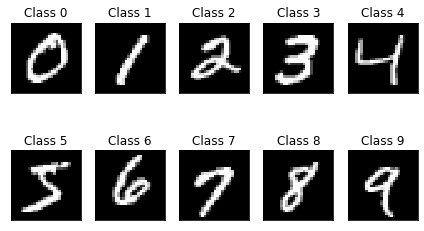

In [28]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [29]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator


In [30]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC
generator.add(Dense(7*7*512, input_shape=(latent_dim,), kernel_initializer=init))
# generator.add(ReLU())
generator.add(Reshape((7, 7, 512)))

# # Conv 1
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2
generator.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Output
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                              activation='tanh'))

#### Generator model visualization

In [31]:
# prints a summary representation of your model
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 25088)             2533888   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 512)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 128)      589952    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 64)      

#### Critic


In [32]:
# Critic network
critic = Sequential()

# imagem shape 28x28x1
img_shape = X_train[0].shape

# Conv 1
critic.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                  input_shape=(img_shape)))
critic.add(LeakyReLU(0.2))

# Conv 2
critic.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# Conv 3
critic.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# Conv 4
critic.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# FC
critic.add(Flatten())

# Output
critic.add(Dense(1))

#### Critic model visualization

In [33]:
# prints a summary representation of your model
critic.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         295168    
                                                      

### 3. Compile model

#### Compile discriminator

In [34]:
# Wasserstein objective
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [35]:
# Following parameter and optimizer set as recommended in paper
n_critic = 5
clip_value = 0.01
optimizer = tf.optimizers.RMSprop(lr=0.00005)

critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#### Combined network

We connect the generator and the critic to make a WGAN.

In [36]:
critic.trainable = False

# The generator takes noise as input and generated imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# The critic takes generated images as input and determines validity
valid = critic(img)

# The combined model (critic and generative)
c_g = Model(inputs=z, outputs=valid, name='wgan')

c_g.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

#### GAN model vizualization

In [37]:
# prints a summary representation of your model
c_g.summary()

Model: "wgan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         3198977   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 1561601   
                                                                 
Total params: 4,760,578
Trainable params: 3,198,593
Non-trainable params: 1,561,985
_________________________________________________________________


### 4. Fit model


In [ ]:
epochs = 100
batch_size = 64

real = -np.ones(shape=(batch_size, 1))
fake = np.ones(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        for _ in range(n_critic):

            # Train Discriminator weights
            critic.trainable = True

            # Real samples
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            d_loss_real = critic.train_on_batch(x=X_batch, y=real)

            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            X_fake = generator.predict(z)
            d_loss_fake = critic.train_on_batch(x=X_fake, y=fake)

            # Discriminator loss
            d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            # Clip critic weights
            for l in critic.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                l.set_weights(weights)

        # Train Generator weights
        critic.trainable = False
        g_loss_batch = c_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()